# PPO Baseline Agent for Super Mario Bros

This notebook implements a **baseline PPO agent** trained on the full action space (COMPLEX_MOVEMENT) with the complete reward function. This baseline will be compared against curriculum-trained agents in our research project.

## Baseline Configuration:
- **Action Space**: COMPLEX_MOVEMENT (12 discrete actions)
- **Reward Function**: Full default reward (velocity + time penalty + death penalty)
- **Levels**: Configurable - can use hardest levels (World 8) or random stages
- **State Space**: Full observation with preprocessing (grayscale, resize, frame stack)

## 1. Imports and Setup

In [1]:
# Core imports
import os
import sys
import time
import datetime
from pathlib import Path
from typing import Callable, Dict, List, Tuple, Optional
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Numerical and visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import pandas as pd

# We use gymnasium for spaces in some contexts
import gymnasium
from gymnasium.spaces import Box

# Super Mario Bros environment (uses old gym internally)
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

# PyTorch
import torch
import torch.nn as nn

# Stable Baselines 3
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecMonitor, VecTransposeImage
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✓ All imports successful!
PyTorch version: 2.9.1
CUDA available: False


## 2. Hyperparameters Configuration

All hyperparameters are centralized here for easy modification and ablation studies.

In [2]:
# ============================================================================
# HYPERPARAMETERS - EASILY MODIFIABLE
# ============================================================================

class Config:
    """Centralized configuration for all hyperparameters."""
    
    # ----- ENVIRONMENT SETTINGS -----
    ENV_NAME = 'SuperMarioBros-v0'  # Options: 'SuperMarioBros-v0', 'SuperMarioBros-1-1-v0', etc.
    # For hardest levels, use specific stages like 'SuperMarioBros-8-4-v0'
    # Or use 'SuperMarioBrosRandomStages-v0' with custom stage selection
    
    ACTION_SPACE = COMPLEX_MOVEMENT  # BASELINE uses full action space
    # Options: RIGHT_ONLY (5 actions), SIMPLE_MOVEMENT (7 actions), COMPLEX_MOVEMENT (12 actions)
    
    # ----- PREPROCESSING SETTINGS -----
    FRAME_SKIP = 4           # Number of frames to skip (repeat same action)
    FRAME_STACK = 4          # Number of frames to stack for temporal info
    RESIZE_SHAPE = (84, 84)  # Resize observation to this shape
    GRAYSCALE = True         # Convert to grayscale
    NORMALIZE = False         # Keep False - SB3 CnnPolicy normalizes internally
    
    # ----- PPO HYPERPARAMETERS -----
    LEARNING_RATE = 2.5e-4       # Initial learning rate
    USE_LR_SCHEDULE = True       # Use linear learning rate decay
    N_STEPS = 128                # Steps per environment per update (rollout buffer size)
    BATCH_SIZE = 256             # Minibatch size for PPO updates
    N_EPOCHS = 4                 # Number of epochs when optimizing the surrogate loss
    GAMMA = 0.99                 # Discount factor
    GAE_LAMBDA = 0.95            # Factor for Generalized Advantage Estimation
    CLIP_RANGE = 0.1             # Clipping parameter for PPO
    CLIP_RANGE_VF = None         # Clipping parameter for value function (None = no clipping)
    ENT_COEF = 0.02              # Entropy coefficient for exploration
    VF_COEF = 0.5                # Value function coefficient in the loss
    MAX_GRAD_NORM = 0.5          # Max gradient norm for clipping
    
    # ----- TRAINING SETTINGS -----
    TOTAL_TIMESTEPS = 1_000_000  # Total timesteps for training
    N_ENVS = 8                   # Number of parallel environments
    EVAL_FREQ = 10000            # Evaluate every N timesteps
    EVAL_EPISODES = 5            # Number of episodes for evaluation
    SAVE_FREQ = 50000            # Save checkpoint every N timesteps
    LOG_INTERVAL = 1             # Log every N updates
    VERBOSE = 1                  # Verbosity level
    
    # ----- PATHS -----
    EXPERIMENT_NAME = f"ppo_baseline_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
    LOG_DIR = Path("./logs") / EXPERIMENT_NAME
    MODEL_DIR = Path("./models") / EXPERIMENT_NAME
    TENSORBOARD_LOG = Path("./tensorboard") / EXPERIMENT_NAME
    
    # ----- DEVICE -----
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    @classmethod
    def create_dirs(cls):
        """Create necessary directories."""
        cls.LOG_DIR.mkdir(parents=True, exist_ok=True)
        cls.MODEL_DIR.mkdir(parents=True, exist_ok=True)
        cls.TENSORBOARD_LOG.mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directories:")
        print(f"  Logs: {cls.LOG_DIR}")
        print(f"  Models: {cls.MODEL_DIR}")
        print(f"  TensorBoard: {cls.TENSORBOARD_LOG}")
    
    @classmethod
    def print_config(cls):
        """Print current configuration."""
        print("="*60)
        print("CONFIGURATION")
        print("="*60)
        print(f"\n--- Environment ---")
        print(f"Environment: {cls.ENV_NAME}")
        print(f"Action Space: {len(cls.ACTION_SPACE)} actions")
        print(f"Actions: {cls.ACTION_SPACE}")
        print(f"\n--- Preprocessing ---")
        print(f"Frame Skip: {cls.FRAME_SKIP}")
        print(f"Frame Stack: {cls.FRAME_STACK}")
        print(f"Resize: {cls.RESIZE_SHAPE}")
        print(f"Grayscale: {cls.GRAYSCALE}")
        print(f"\n--- PPO Hyperparameters ---")
        print(f"Learning Rate: {cls.LEARNING_RATE}")
        print(f"N Steps: {cls.N_STEPS}")
        print(f"Batch Size: {cls.BATCH_SIZE}")
        print(f"N Epochs: {cls.N_EPOCHS}")
        print(f"Gamma: {cls.GAMMA}")
        print(f"GAE Lambda: {cls.GAE_LAMBDA}")
        print(f"Clip Range: {cls.CLIP_RANGE}")
        print(f"Entropy Coef: {cls.ENT_COEF}")
        print(f"\n--- Training ---")
        print(f"Total Timesteps: {cls.TOTAL_TIMESTEPS:,}")
        print(f"N Envs: {cls.N_ENVS}")
        print(f"Device: {cls.DEVICE}")
        print("="*60)

# Print and create directories
Config.print_config()
Config.create_dirs()

CONFIGURATION

--- Environment ---
Environment: SuperMarioBros-v0
Action Space: 12 actions
Actions: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]

--- Preprocessing ---
Frame Skip: 4
Frame Stack: 4
Resize: (84, 84)
Grayscale: True

--- PPO Hyperparameters ---
Learning Rate: 0.00025
N Steps: 128
Batch Size: 256
N Epochs: 4
Gamma: 0.99
GAE Lambda: 0.95
Clip Range: 0.1
Entropy Coef: 0.01

--- Training ---
Total Timesteps: 1,000,000
N Envs: 8
Device: cpu
✓ Created directories:
  Logs: logs/ppo_baseline_20251130_151219
  Models: models/ppo_baseline_20251130_151219
  TensorBoard: tensorboard/ppo_baseline_20251130_151219


## 3. Custom Wrappers for Gymnasium Compatibility

These wrappers handle the preprocessing and ensure compatibility with the patched gym-super-mario-bros environment.

In [14]:
# ============================================================================
# CUSTOM WRAPPERS (Compatible with gym-super-mario-bros and Stable Baselines 3)
# ============================================================================
# Note: gym-super-mario-bros uses the OLD gym library, not gymnasium.
# We inherit from gym.Wrapper for internal wrappers, then use a final
# GymnasiumCompatibilityWrapper that inherits from gymnasium.Env to make
# the environment compatible with Stable Baselines 3.

import gym  # Old gym (required by gym-super-mario-bros)
from gym import Wrapper as GymWrapper
from gym.spaces import Box as GymBox
import gymnasium
from gymnasium.spaces import Box as GymnasiumBox
from gymnasium.spaces import Discrete as GymnasiumDiscrete
import cv2

class SkipFrame(GymWrapper):
    """
    Skip frames and repeat the same action.
    Accumulates rewards during skipped frames.
    """
    def __init__(self, env, skip: int = 4):
        super().__init__(env)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        for _ in range(self._skip):
            result = self.env.step(action)
            # Handle both 4-tuple and 5-tuple returns
            if len(result) == 5:
                obs, reward, terminated, truncated, info = result
            else:
                obs, reward, done, info = result
                terminated, truncated = done, False
            total_reward += reward
            if terminated or truncated:
                break
        return obs, total_reward, terminated, truncated, info


class GrayScaleObservation(GymWrapper):
    """
    Convert RGB observation to grayscale.
    """
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = GymBox(
            low=0, high=255, shape=(*obs_shape, 1), dtype=np.uint8
        )
    
    def _process_obs(self, observation):
        gray = np.dot(observation[..., :3], [0.299, 0.587, 0.114])
        return gray.astype(np.uint8)[..., np.newaxis]
        
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            return self._process_obs(obs), reward, terminated, truncated, info
        else:
            obs, reward, done, info = result
            return self._process_obs(obs), reward, done, False, info
    
    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return self._process_obs(obs), info
        return self._process_obs(result), {}


class ResizeObservation(GymWrapper):
    """
    Resize observation to specified shape.
    """
    def __init__(self, env, shape: Tuple[int, int]):
        super().__init__(env)
        self.shape = shape
        obs_shape = (*shape, self.observation_space.shape[-1])
        self.observation_space = GymBox(
            low=0, high=255, shape=obs_shape, dtype=np.uint8
        )
    
    def _process_obs(self, observation):
        resized = cv2.resize(
            observation, 
            self.shape, 
            interpolation=cv2.INTER_AREA
        )
        if len(resized.shape) == 2:
            resized = resized[..., np.newaxis]
        return resized
        
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            return self._process_obs(obs), reward, terminated, truncated, info
        else:
            obs, reward, done, info = result
            return self._process_obs(obs), reward, done, False, info
    
    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return self._process_obs(obs), info
        return self._process_obs(result), {}


class NormalizeObservation(GymWrapper):
    """
    Normalize observation to [0, 1] range.
    Note: Usually not needed as SB3's CnnPolicy normalizes internally.
    """
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = GymBox(
            low=0.0, 
            high=1.0, 
            shape=self.observation_space.shape, 
            dtype=np.float32
        )
    
    def _process_obs(self, observation):
        return (observation / 255.0).astype(np.float32)
        
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            return self._process_obs(obs), reward, terminated, truncated, info
        else:
            obs, reward, done, info = result
            return self._process_obs(obs), reward, done, False, info
    
    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return self._process_obs(obs), info
        return self._process_obs(result), {}


class EpisodeInfoWrapper(GymWrapper):
    """
    Track episode statistics for logging.
    
    IMPORTANT: Stores episode stats in 'mario_episode' key (not 'episode')
    because SB3's VecMonitor OVERWRITES info['episode'].
    
    Also stores max_x_pos (not just final x_pos) for better progress tracking.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_reward = 0.0
        self.episode_length = 0
        self.max_x_pos = 0  # Track MAXIMUM x position (not current)
        self.current_x_pos = 0
        self.episodes_completed = 0
        self.flags_gotten = 0
        
    def reset(self, **kwargs):
        self.episode_reward = 0.0
        self.episode_length = 0
        self.max_x_pos = 0
        self.current_x_pos = 0
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            return result
        return result, {}
    
    def step(self, action):
        result = self.env.step(action)
        
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
        else:
            obs, reward, done, info = result
            terminated, truncated = done, False
        
        self.episode_reward += reward
        self.episode_length += 1
        
        # Track current and max x position
        self.current_x_pos = info.get('x_pos', 0)
        self.max_x_pos = max(self.max_x_pos, self.current_x_pos)
        
        if terminated or truncated:
            self.episodes_completed += 1
            flag_get = info.get('flag_get', False)
            if flag_get:
                self.flags_gotten += 1
            
            # Store in 'mario_episode' - VecMonitor won't touch this!
            info['mario_episode'] = {
                'r': self.episode_reward,
                'l': self.episode_length,
                'x_pos': self.max_x_pos,  # Use MAX x_pos for the episode
                'final_x_pos': self.current_x_pos,
                'flag_get': flag_get,
                'score': info.get('score', 0),
                'time': info.get('time', 0),
                'world': info.get('world', 1),
                'stage': info.get('stage', 1),
            }
            
            # Also store at top level for easy access
            info['episode_x_pos'] = self.max_x_pos
            info['episode_flag_get'] = flag_get
            
        return obs, reward, terminated, truncated, info


class GymnasiumCompatibilityWrapper(gymnasium.Env):
    """
    Final wrapper that makes the environment fully gymnasium-compatible.
    This inherits from gymnasium.Env so that Stable Baselines 3 recognizes
    it as a gymnasium environment and doesn't try to use shimmy conversion.
    
    MUST be the outermost wrapper (applied last).
    """
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(self, env):
        super().__init__()
        self.env = env
        
        # Convert observation space to gymnasium format
        old_obs_space = env.observation_space
        self.observation_space = GymnasiumBox(
            low=old_obs_space.low.min(),
            high=old_obs_space.high.max(),
            shape=old_obs_space.shape,
            dtype=old_obs_space.dtype
        )
        
        # Convert action space to gymnasium format
        old_action_space = env.action_space
        self.action_space = GymnasiumDiscrete(old_action_space.n)
        
        # Copy other attributes
        self.reward_range = getattr(env, 'reward_range', (-float('inf'), float('inf')))
        self.spec = getattr(env, 'spec', None)
    
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
        else:
            obs, reward, done, info = result
            terminated, truncated = done, False
        return obs, float(reward), bool(terminated), bool(truncated), info
    
    def reset(self, seed=None, options=None):
        # Handle seed if provided
        if seed is not None and hasattr(self.env, 'seed'):
            self.env.seed(seed)
        
        result = self.env.reset()
        if isinstance(result, tuple):
            obs, info = result
        else:
            obs, info = result, {}
        return obs, info
    
    def render(self):
        if hasattr(self.env, 'render'):
            return self.env.render()
        return None
    
    def close(self):
        if hasattr(self.env, 'close'):
            return self.env.close()
    
    @property
    def unwrapped(self):
        return self.env.unwrapped if hasattr(self.env, 'unwrapped') else self.env


print("✓ Wrappers defined successfully!")
print("  - EpisodeInfoWrapper now stores data in 'mario_episode' key")
print("  - Tracks MAX x_pos per episode (not just final)")

✓ Wrappers defined successfully!
  - EpisodeInfoWrapper now stores data in 'mario_episode' key
  - Tracks MAX x_pos per episode (not just final)


## 4. Environment Factory

In [15]:
# ============================================================================
# ENVIRONMENT FACTORY
# ============================================================================

def make_mario_env(
    env_name: str = Config.ENV_NAME,
    action_space = Config.ACTION_SPACE,
    frame_skip: int = Config.FRAME_SKIP,
    resize_shape: Tuple[int, int] = Config.RESIZE_SHAPE,
    grayscale: bool = Config.GRAYSCALE,
    normalize: bool = Config.NORMALIZE,
    rank: int = 0,
    seed: int = 0
):
    """
    Factory function to create a preprocessed Mario environment.
    
    Args:
        env_name: Name of the environment
        action_space: Action space to use (RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT)
        frame_skip: Number of frames to skip
        resize_shape: Shape to resize observations to
        grayscale: Whether to convert to grayscale
        normalize: Whether to normalize pixel values
        rank: Rank of the environment (for parallel envs)
        seed: Random seed
    
    Returns:
        Callable that creates the environment
    """
    def _init():
        # Create base environment
        env = gym_super_mario_bros.make(env_name)
        
        # Apply JoypadSpace wrapper for action space
        env = JoypadSpace(env, action_space)
        
        # Episode info tracking
        env = EpisodeInfoWrapper(env)
        
        # Frame skipping
        if frame_skip > 1:
            env = SkipFrame(env, skip=frame_skip)
        
        # Grayscale
        if grayscale:
            env = GrayScaleObservation(env)
        
        # Resize
        if resize_shape is not None:
            env = ResizeObservation(env, shape=resize_shape)
        
        # Normalize (usually False - SB3 CnnPolicy normalizes internally)
        if normalize:
            env = NormalizeObservation(env)
        
        # IMPORTANT: Final wrapper to make it gymnasium-compatible for SB3
        # This MUST be the last wrapper applied
        env = GymnasiumCompatibilityWrapper(env)
        
        return env
    
    return _init


def create_vectorized_env(
    n_envs: int = Config.N_ENVS,
    frame_stack: int = Config.FRAME_STACK,
    **kwargs
):
    """
    Create vectorized environment with frame stacking.
    
    Args:
        n_envs: Number of parallel environments
        frame_stack: Number of frames to stack
        **kwargs: Additional arguments passed to make_mario_env
    
    Returns:
        Vectorized environment
    """
    # Create environment factories
    env_fns = [make_mario_env(rank=i, **kwargs) for i in range(n_envs)]
    
    # Create vectorized environment
    vec_env = DummyVecEnv(env_fns)
    
    # Add monitoring
    vec_env = VecMonitor(vec_env)
    
    # Add frame stacking
    if frame_stack > 1:
        vec_env = VecFrameStack(vec_env, n_stack=frame_stack, channels_order='last')
    
    # Transpose for PyTorch (channels first)
    vec_env = VecTransposeImage(vec_env)
    
    return vec_env


print("✓ Environment factory defined!")

✓ Environment factory defined!


## 5. Verify Environment Setup

In [5]:
# ============================================================================
# VERIFY ENVIRONMENT
# ============================================================================

print("Testing environment setup...\n")

# Create single test environment
test_env_fn = make_mario_env()
test_env = test_env_fn()

print(f"✓ Environment created: {Config.ENV_NAME}")
print(f"  Environment type: {type(test_env).__name__}")
print(f"  Is gymnasium.Env: {isinstance(test_env, gymnasium.Env)}")
print(f"  Observation space: {test_env.observation_space}")
print(f"  Action space: {test_env.action_space}")
print(f"  Number of actions: {test_env.action_space.n}")

# Test reset
obs, info = test_env.reset()
print(f"\n✓ Reset successful")
print(f"  Observation shape: {obs.shape}")
print(f"  Observation dtype: {obs.dtype}")
print(f"  Observation range: [{obs.min():.3f}, {obs.max():.3f}]")

# Test step
action = test_env.action_space.sample()
obs, reward, terminated, truncated, info = test_env.step(action)

print(f"\n✓ Step returns 5 values (gymnasium-compatible)")
print(f"  Reward: {reward}")
print(f"  Terminated: {terminated}")
print(f"  Truncated: {truncated}")
print(f"  Info keys: {list(info.keys())}")

# Close test environment
test_env.close()

# Test vectorized environment
print("\n" + "-"*50)
print("Testing vectorized environment...\n")

vec_env = create_vectorized_env(n_envs=2)
print(f"✓ Vectorized environment created")
print(f"  Number of envs: {vec_env.num_envs}")
print(f"  Observation space: {vec_env.observation_space}")
print(f"  Action space: {vec_env.action_space}")

obs = vec_env.reset()
print(f"  Observation shape after reset: {obs.shape}")
print(f"  Expected shape: (2, {Config.FRAME_STACK}, {Config.RESIZE_SHAPE[0]}, {Config.RESIZE_SHAPE[1]})")

# Test a few steps
for i in range(5):
    actions = [vec_env.action_space.sample() for _ in range(vec_env.num_envs)]
    obs, rewards, dones, infos = vec_env.step(actions)

print(f"  Observation shape after steps: {obs.shape}")
print(f"  Observation dtype: {obs.dtype}")

vec_env.close()
print("\n✓ All environment tests passed!")

Testing environment setup...

✓ Environment created: SuperMarioBros-v0
  Environment type: GymnasiumCompatibilityWrapper
  Is gymnasium.Env: True
  Observation space: Box(0, 255, (84, 84, 1), uint8)
  Action space: Discrete(12)
  Number of actions: 12

✓ Reset successful
  Observation shape: (84, 84, 1)
  Observation dtype: uint8
  Observation range: [21.000, 252.000]

✓ Step returns 5 values (gymnasium-compatible)
  Reward: 0.0
  Terminated: False
  Truncated: False
  Info keys: ['coins', 'flag_get', 'life', 'score', 'stage', 'status', 'time', 'world', 'x_pos', 'y_pos']

--------------------------------------------------
Testing vectorized environment...

✓ Vectorized environment created
  Number of envs: 2
  Observation space: Box(0, 255, (4, 84, 84), uint8)
  Action space: Discrete(12)
  Observation shape after reset: (2, 4, 84, 84)
  Expected shape: (2, 4, 84, 84)
  Observation shape after steps: (2, 4, 84, 84)
  Observation dtype: uint8

✓ All environment tests passed!


## 6. Visualize Preprocessed Observations

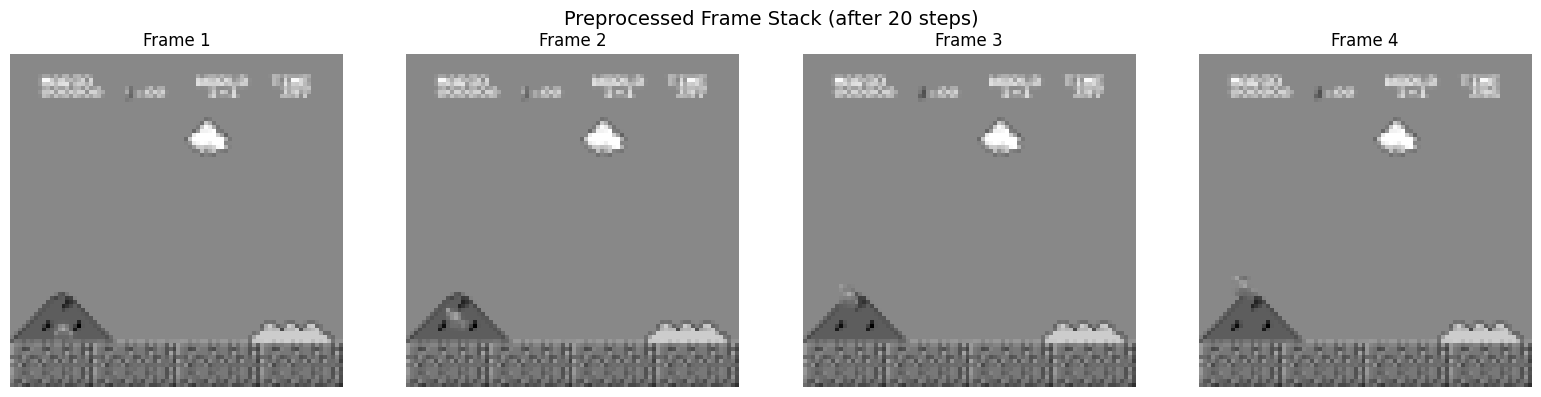

In [6]:
# ============================================================================
# VISUALIZE OBSERVATIONS
# ============================================================================

def visualize_frame_stack(obs, title="Frame Stack Visualization"):
    """
    Visualize stacked frames from the environment.
    
    Args:
        obs: Observation array (channels, height, width) or (batch, channels, height, width)
        title: Title for the plot
    """
    # Handle batched observations
    if len(obs.shape) == 4:
        obs = obs[0]  # Take first environment
    
    n_frames = obs.shape[0]
    
    fig, axes = plt.subplots(1, n_frames, figsize=(4*n_frames, 4))
    fig.suptitle(title, fontsize=14)
    
    for i in range(n_frames):
        ax = axes[i] if n_frames > 1 else axes
        frame = obs[i]
        ax.imshow(frame, cmap='gray')
        ax.set_title(f"Frame {i+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Create environment and visualize
vec_env = create_vectorized_env(n_envs=1)
obs = vec_env.reset()

# Take a few random steps to see different frames
for _ in range(20):
    action = [vec_env.action_space.sample()]
    obs, _, _, _ = vec_env.step(action)

visualize_frame_stack(obs, "Preprocessed Frame Stack (after 20 steps)")

vec_env.close()

## 7. Custom CNN Feature Extractor

In [7]:
# ============================================================================
# CUSTOM CNN FEATURE EXTRACTOR
# ============================================================================

class MarioCNN(BaseFeaturesExtractor):
    """
    Custom CNN feature extractor for Mario.
    Architecture inspired by Nature DQN paper.
    """
    def __init__(self, observation_space, features_dim: int = 512):
        super().__init__(observation_space, features_dim)
        
        n_input_channels = observation_space.shape[0]
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        # Compute the output size of CNN
        with torch.no_grad():
            sample = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample).shape[1]
        
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )
    
    def forward(self, observations):
        return self.linear(self.cnn(observations))


# Policy kwargs for PPO
policy_kwargs = dict(
    features_extractor_class=MarioCNN,
    features_extractor_kwargs=dict(features_dim=512),
    net_arch=dict(pi=[256], vf=[256]),  # Separate networks for policy and value
    activation_fn=nn.ReLU,
)

print("✓ Custom CNN feature extractor defined!")
print(f"  Features dimension: 512")
print(f"  Policy network: [256]")
print(f"  Value network: [256]")

✓ Custom CNN feature extractor defined!
  Features dimension: 512
  Policy network: [256]
  Value network: [256]


## 8. Training Callbacks

In [8]:
# ============================================================================
# TRAINING CALLBACKS
# ============================================================================

import time as _time  # Import at module level to avoid recursion issues

class TrainingMetricsCallback(BaseCallback):
    """
    Custom callback to track and save training metrics.
    
    IMPORTANT: Reads from 'mario_episode' key (not 'episode') because
    SB3's VecMonitor overwrites info['episode'].
    """
    def __init__(self, check_freq: int = 1000, log_dir: Path = None, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.metrics = {
            'timesteps': [],
            'episode_rewards': [],
            'episode_lengths': [],
            'x_positions': [],
            'flags_gotten': []
        }
        self.episode_rewards = deque(maxlen=100)
        self.episode_lengths = deque(maxlen=100)
        self.x_positions = deque(maxlen=100)
        self.flags_gotten = deque(maxlen=100)
        
    def _on_step(self) -> bool:
        # Check for episode completions in info
        for info in self.locals.get('infos', []):
            # Read from 'mario_episode' - our custom key that VecMonitor doesn't touch
            if 'mario_episode' in info:
                ep_info = info['mario_episode']
                self.episode_rewards.append(ep_info['r'])
                self.episode_lengths.append(ep_info['l'])
                self.x_positions.append(ep_info.get('x_pos', 0))
                self.flags_gotten.append(1 if ep_info.get('flag_get', False) else 0)
            # Fallback: also check top-level keys we set
            elif 'episode_x_pos' in info:
                # Get reward/length from VecMonitor's 'episode' key
                if 'episode' in info:
                    vec_ep = info['episode']
                    self.episode_rewards.append(vec_ep.get('r', 0))
                    self.episode_lengths.append(vec_ep.get('l', 0))
                self.x_positions.append(info.get('episode_x_pos', 0))
                self.flags_gotten.append(1 if info.get('episode_flag_get', False) else 0)
        
        # Log metrics at check_freq
        if self.n_calls % self.check_freq == 0 and len(self.episode_rewards) > 0:
            self.metrics['timesteps'].append(self.num_timesteps)
            self.metrics['episode_rewards'].append(np.mean(self.episode_rewards))
            self.metrics['episode_lengths'].append(np.mean(self.episode_lengths))
            self.metrics['x_positions'].append(np.mean(self.x_positions))
            self.metrics['flags_gotten'].append(np.mean(self.flags_gotten))
            
            if self.verbose > 0:
                print(f"  Step {self.num_timesteps:,}: "
                      f"reward={np.mean(self.episode_rewards):.1f}, "
                      f"x_pos={np.mean(self.x_positions):.0f}, "
                      f"flags={np.sum(self.flags_gotten)}/{len(self.flags_gotten)}")
        
        return True
    
    def _on_training_end(self):
        # Save metrics to CSV
        if self.log_dir:
            self.log_dir.mkdir(parents=True, exist_ok=True)
            df = pd.DataFrame(self.metrics)
            df.to_csv(self.log_dir / 'training_metrics.csv', index=False)
            if self.verbose > 0:
                print(f"\n✓ Metrics saved to {self.log_dir / 'training_metrics.csv'}")
    
    def get_metrics(self):
        """Return collected metrics."""
        return self.metrics


class SaveBestModelCallback(BaseCallback):
    """
    Callback to save the best model based on mean reward.
    """
    def __init__(self, save_path: Path, check_freq: int = 10000, verbose: int = 1):
        super().__init__(verbose)
        self.save_path = save_path
        self.check_freq = check_freq
        self.best_mean_reward = -np.inf
        self.episode_rewards = deque(maxlen=100)
        
    def _on_step(self) -> bool:
        # Track episode rewards - check both our key and VecMonitor's key
        for info in self.locals.get('infos', []):
            if 'mario_episode' in info:
                self.episode_rewards.append(info['mario_episode']['r'])
            elif 'episode' in info:
                self.episode_rewards.append(info['episode']['r'])
        
        # Check if we should evaluate
        if self.n_calls % self.check_freq == 0 and len(self.episode_rewards) >= 10:
            mean_reward = np.mean(self.episode_rewards)
            
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.save_path.mkdir(parents=True, exist_ok=True)
                save_file = self.save_path / 'best_model'
                self.model.save(save_file)
                if self.verbose > 0:
                    print(f"  ★ New best model! Mean reward: {mean_reward:.2f} -> {save_file}")
        
        return True


class HeartbeatCallback(BaseCallback):
    """
    Callback that prints periodic status updates to prevent silent timeouts.
    Also helps detect if training has stalled.
    
    Note: Uses module-level _time import to avoid recursion issues with inspect.
    """
    def __init__(self, interval: int = 30, verbose: int = 1):
        super().__init__(verbose)
        self.interval = interval  # seconds between heartbeats
        self.last_heartbeat = None
        self.last_timestep = 0
        self.start_time = None
        
    def _on_training_start(self):
        self.start_time = _time.time()
        self.last_heartbeat = _time.time()
        self.last_timestep = 0
        if self.verbose > 0:
            print(f"[Heartbeat] Training started at {datetime.datetime.now().strftime('%H:%M:%S')}")
        
    def _on_step(self) -> bool:
        current_time = _time.time()
        
        # Print heartbeat every interval seconds
        if current_time - self.last_heartbeat >= self.interval:
            elapsed = current_time - self.start_time
            steps_since_last = self.num_timesteps - self.last_timestep
            steps_per_sec = steps_since_last / self.interval if self.interval > 0 else 0
            
            # Calculate ETA
            total_timesteps = self.locals.get('total_timesteps', Config.TOTAL_TIMESTEPS)
            remaining_steps = total_timesteps - self.num_timesteps
            eta_seconds = remaining_steps / steps_per_sec if steps_per_sec > 0 else 0
            
            hours = int(elapsed // 3600)
            minutes = int((elapsed % 3600) // 60)
            seconds = int(elapsed % 60)
            
            eta_hours = int(eta_seconds // 3600)
            eta_minutes = int((eta_seconds % 3600) // 60)
            
            if self.verbose > 0:
                print(f"[Heartbeat] {self.num_timesteps:,}/{total_timesteps:,} steps "
                      f"({100*self.num_timesteps/total_timesteps:.1f}%) | "
                      f"Elapsed: {hours}h{minutes:02d}m{seconds:02d}s | "
                      f"Speed: {steps_per_sec:.0f} steps/s | "
                      f"ETA: {eta_hours}h{eta_minutes:02d}m")
            
            self.last_heartbeat = current_time
            self.last_timestep = self.num_timesteps
            
            # Flush output to ensure it's displayed
            sys.stdout.flush()
        
        return True
    
    def _on_training_end(self):
        if self.verbose > 0 and self.start_time is not None:
            elapsed = _time.time() - self.start_time
            hours = int(elapsed // 3600)
            minutes = int((elapsed % 3600) // 60)
            seconds = int(elapsed % 60)
            print(f"[Heartbeat] Training ended. Total time: {hours}h{minutes:02d}m{seconds:02d}s")


print("✓ Callbacks defined: TrainingMetricsCallback, SaveBestModelCallback, HeartbeatCallback")
print("  - TrainingMetricsCallback now reads from 'mario_episode' key")

✓ Callbacks defined: TrainingMetricsCallback, SaveBestModelCallback, HeartbeatCallback
  - TrainingMetricsCallback now reads from 'mario_episode' key


## 9. Learning Rate Schedule

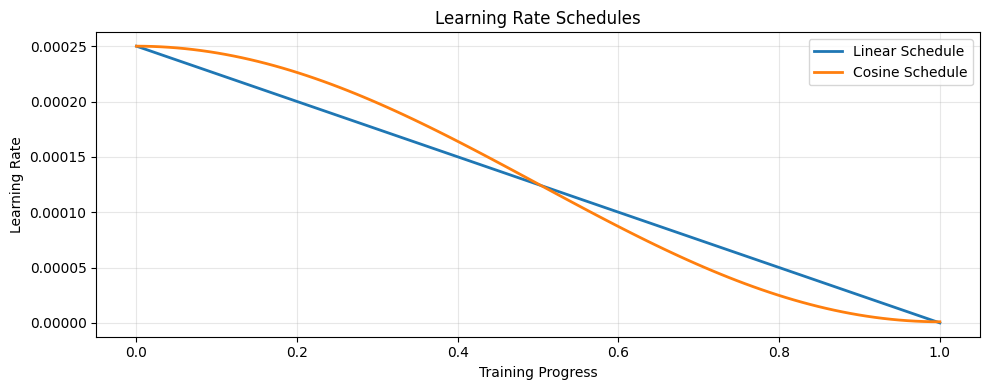

✓ Learning rate schedules defined!


In [9]:
# ============================================================================
# LEARNING RATE SCHEDULE
# ============================================================================

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.
    
    Args:
        initial_value: Initial learning rate
    
    Returns:
        Schedule function that computes current learning rate
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0 (end).
        """
        return progress_remaining * initial_value
    return func


def cosine_schedule(initial_value: float, min_value: float = 1e-6) -> Callable[[float], float]:
    """
    Cosine annealing learning rate schedule.
    """
    def func(progress_remaining: float) -> float:
        return min_value + 0.5 * (initial_value - min_value) * (1 + np.cos(np.pi * (1 - progress_remaining)))
    return func


# Visualize learning rate schedules
progress = np.linspace(1, 0, 100)
linear_lr = [linear_schedule(Config.LEARNING_RATE)(p) for p in progress]
cosine_lr = [cosine_schedule(Config.LEARNING_RATE)(p) for p in progress]

plt.figure(figsize=(10, 4))
plt.plot(1 - progress, linear_lr, label='Linear Schedule', linewidth=2)
plt.plot(1 - progress, cosine_lr, label='Cosine Schedule', linewidth=2)
plt.xlabel('Training Progress')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedules')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Learning rate schedules defined!")

In [10]:
# ============================================================================
# TENSORBOARD DIAGNOSTICS (Optional - Run if TensorBoard issues)
# ============================================================================
# This cell diagnoses TensorBoard installation issues.
# Run it if you encounter TensorBoard import errors during training.

print("TensorBoard Diagnostic")
print("="*50)

# Check tensorboard package
try:
    import tensorboard
    print(f"✓ tensorboard package version: {tensorboard.__version__}")
except ImportError as e:
    print(f"✗ tensorboard package not found: {e}")

# Check torch.utils.tensorboard (direct import)
try:
    from torch.utils.tensorboard import SummaryWriter
    print(f"✓ torch.utils.tensorboard.SummaryWriter importable")
    # Try creating a writer
    import tempfile
    with tempfile.TemporaryDirectory() as tmpdir:
        writer = SummaryWriter(tmpdir)
        writer.close()
        print(f"✓ SummaryWriter creation works")
except ImportError as e:
    print(f"✗ torch.utils.tensorboard import failed: {e}")
except Exception as e:
    print(f"✗ SummaryWriter creation failed: {e}")

# Check what SB3 thinks about TensorBoard
from stable_baselines3.common import utils as sb3_utils
sb3_has_tb = hasattr(sb3_utils, 'SummaryWriter') and sb3_utils.SummaryWriter is not None
print(f"{'✓' if sb3_has_tb else '✗'} SB3 internal SummaryWriter: {'Available' if sb3_has_tb else 'None'}")

# Check protobuf (common cause of tensorboard issues)
try:
    import google.protobuf
    print(f"✓ protobuf version: {google.protobuf.__version__}")
except ImportError as e:
    print(f"✗ protobuf not found: {e}")

print("\n" + "="*50)
if not sb3_has_tb:
    print("⚠ TensorBoard is NOT available for Stable Baselines 3")
    print("\nTo fix this issue, try the following in your terminal:")
    print("  1. pip uninstall tensorboard tensorboard-data-server -y")
    print("  2. pip install tensorboard==2.14.0 --break-system-packages")
    print("  3. Restart your Jupyter kernel completely")
    print("\nAlternatively, training will work fine without TensorBoard.")
    print("Metrics are also saved to CSV files.")
else:
    print("✓ TensorBoard is properly configured!")

TensorBoard Diagnostic
✓ tensorboard package version: 2.14.0
✓ torch.utils.tensorboard.SummaryWriter importable
✓ SummaryWriter creation works
✓ SB3 internal SummaryWriter: Available
✓ protobuf version: 6.33.1

✓ TensorBoard is properly configured!


## 10. Create and Initialize PPO Model

In [11]:
# ============================================================================
# CREATE PPO MODEL
# ============================================================================

# Check if TensorBoard is ACTUALLY available for Stable Baselines 3
# SB3 caches its own import check at module load time, so we need to check
# SB3's internal state, not just try importing ourselves.

from stable_baselines3.common import utils as sb3_utils

# Check SB3's internal SummaryWriter (this is what SB3 actually uses)
tensorboard_available = hasattr(sb3_utils, 'SummaryWriter') and sb3_utils.SummaryWriter is not None

if tensorboard_available:
    print("✓ TensorBoard is available (SB3 internal check passed)")
else:
    print("⚠ TensorBoard not available for Stable Baselines 3")
    print("  This usually happens due to version mismatches.")
    print("  Training will proceed without TensorBoard logging.")
    print("\n  To fix, try running in your terminal:")
    print("    pip uninstall tensorboard tensorboard-data-server -y")
    print("    pip install tensorboard==2.14.0 --break-system-packages")
    print("    # Then restart your Jupyter kernel")

# Set tensorboard log path (None if not available)
tb_log_path = str(Config.TENSORBOARD_LOG) if tensorboard_available else None

# Create vectorized environment
print("\nCreating training environment...")
train_env = create_vectorized_env(n_envs=Config.N_ENVS)
print(f"✓ Training environment ready: {Config.N_ENVS} parallel envs")

# Create evaluation environment
print("\nCreating evaluation environment...")
eval_env = create_vectorized_env(n_envs=1)
print(f"✓ Evaluation environment ready")

# Set up learning rate
if Config.USE_LR_SCHEDULE:
    learning_rate = linear_schedule(Config.LEARNING_RATE)
    print(f"\nUsing linear learning rate schedule (initial: {Config.LEARNING_RATE})")
else:
    learning_rate = Config.LEARNING_RATE
    print(f"\nUsing constant learning rate: {Config.LEARNING_RATE}")

# Create PPO model
print("\nInitializing PPO model...")
model = PPO(
    policy='CnnPolicy',
    env=train_env,
    learning_rate=learning_rate,
    n_steps=Config.N_STEPS,
    batch_size=Config.BATCH_SIZE,
    n_epochs=Config.N_EPOCHS,
    gamma=Config.GAMMA,
    gae_lambda=Config.GAE_LAMBDA,
    clip_range=Config.CLIP_RANGE,
    clip_range_vf=Config.CLIP_RANGE_VF,
    ent_coef=Config.ENT_COEF,
    vf_coef=Config.VF_COEF,
    max_grad_norm=Config.MAX_GRAD_NORM,
    policy_kwargs=policy_kwargs,
    tensorboard_log=tb_log_path,  # None if tensorboard not available
    verbose=Config.VERBOSE,
    device=Config.DEVICE
)

print(f"\n✓ PPO Model created!")
print(f"  Policy: {model.policy.__class__.__name__}")
print(f"  Device: {model.device}")
print(f"  TensorBoard logging: {'Enabled' if tb_log_path else 'Disabled (metrics saved to CSV)'}")

# Print model summary
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model.policy)

✓ TensorBoard is available (SB3 internal check passed)

Creating training environment...
✓ Training environment ready: 8 parallel envs

Creating evaluation environment...
✓ Evaluation environment ready

Using linear learning rate schedule (initial: 0.00025)

Initializing PPO model...
Using cpu device

✓ PPO Model created!
  Policy: ActorCriticCnnPolicy
  Device: cpu
  TensorBoard logging: Enabled

MODEL ARCHITECTURE
ActorCriticCnnPolicy(
  (features_extractor): MarioCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): MarioCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size

## 10b. Evaluation Function

This function is used by both trial run and full training to evaluate the trained model.

In [12]:
# ============================================================================
# EVALUATE TRAINED MODEL
# ============================================================================

def evaluate_model(
    model, 
    env, 
    n_episodes: int = 10,
    deterministic: bool = False,
    verbose: bool = True
) -> Dict:
    """
    Evaluate the trained model.
    
    Args:
        model: Trained PPO model
        env: Evaluation environment
        n_episodes: Number of episodes to evaluate
        deterministic: Use deterministic actions (False gives more variance)
        verbose: Print episode details
    
    Returns:
        Dictionary containing evaluation metrics.
        Note: completion_rate is returned as a FRACTION (0.0-1.0), not percentage.
    """
    episode_rewards = []
    episode_lengths = []
    episode_x_positions = []
    flags_gotten = []
    
    for episode in range(n_episodes):
        obs = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        max_x_pos = 0
        flag_get = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, info = env.step(action)
            
            episode_reward += reward[0]
            episode_length += 1
            
            # Track x position from info (at top level from Mario env)
            current_x = info[0].get('x_pos', 0)
            max_x_pos = max(max_x_pos, current_x)
            
            # Check for flag
            if info[0].get('flag_get', False):
                flag_get = True
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_x_positions.append(max_x_pos)
        flags_gotten.append(1 if flag_get else 0)
        
        if verbose:
            flag_str = "✓ FLAG" if flag_get else ""
            print(f"Episode {episode+1:3d}: Reward={episode_reward:8.2f}, "
                  f"Length={episode_length:5d}, X_pos={max_x_pos:5d} {flag_str}")
    
    # completion_rate is a FRACTION (0.0-1.0)
    completion_rate = np.mean(flags_gotten)
    
    results = {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_length': np.mean(episode_lengths),
        'std_length': np.std(episode_lengths),
        'mean_x_pos': np.mean(episode_x_positions),
        'std_x_pos': np.std(episode_x_positions),
        'max_x_pos': np.max(episode_x_positions),
        'min_x_pos': np.min(episode_x_positions),
        'total_flags': np.sum(flags_gotten),
        'completion_rate': completion_rate,  # FRACTION, not percentage!
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'episode_x_positions': episode_x_positions
    }
    
    print("\n" + "="*50)
    print("EVALUATION SUMMARY")
    print("="*50)
    print(f"Episodes: {n_episodes}")
    print(f"Mean Reward: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}")
    print(f"Mean Episode Length: {results['mean_length']:.2f} ± {results['std_length']:.2f}")
    print(f"Mean X Position: {results['mean_x_pos']:.2f} ± {results['std_x_pos']:.2f}")
    print(f"X Position Range: [{results['min_x_pos']}, {results['max_x_pos']}]")
    print(f"Level Completions: {results['total_flags']}/{n_episodes}")
    print(f"Completion Rate: {results['completion_rate']*100:.1f}%")
    
    # Warn if no variance (might indicate policy collapse)
    if results['std_reward'] == 0 and n_episodes > 1:
        print("\n⚠ WARNING: Zero variance in rewards!")
        print("  This might indicate the policy has collapsed to a single action.")
        print("  Try running with deterministic=False to see stochastic behavior.")
    
    return results


print("✓ evaluate_model function defined!")

✓ evaluate_model function defined!


## 11a. Trial Run (Quick Verification)

Run this cell FIRST to verify everything works end-to-end before committing to full training.
This runs a short training session (~50k steps), evaluates the agent, and plots results.


In [13]:
# ============================================================================
# TRIAL RUN - Quick End-to-End Verification
# ============================================================================
# This runs a SHORT training session using THE EXACT SAME code as full training.
# The ONLY differences are: fewer timesteps, separate model/env instances.
# Takes ~2-5 minutes depending on hardware.

TRIAL_TIMESTEPS = 50_000  # Short run for verification

print("="*60)
print("TRIAL RUN - End-to-End Verification")
print("="*60)
print(f"Trial timesteps: {TRIAL_TIMESTEPS:,}")
print(f"Using same Config values as full training")
print("="*60 + "\n")

# Create trial directories (separate from main training)
trial_log_dir = Path("./logs/trial_run")
trial_model_dir = Path("./models/trial_run")
trial_log_dir.mkdir(parents=True, exist_ok=True)
trial_model_dir.mkdir(parents=True, exist_ok=True)

# Create environments using THE SAME function as full training
# (Using 4 envs instead of N_ENVS for faster startup in trial)
print("Creating trial environments...")
trial_n_envs = min(4, Config.N_ENVS)  # Use fewer envs for trial
trial_train_env = create_vectorized_env(n_envs=trial_n_envs)
trial_eval_env = create_vectorized_env(n_envs=1)
print(f"✓ Trial environments ready ({trial_n_envs} training envs)")

# Create trial model using THE SAME configuration as full training
# (Using a separate model instance to not affect the main model)
print("\nCreating trial model...")

# Use same learning rate setup as full training
if Config.USE_LR_SCHEDULE:
    trial_learning_rate = linear_schedule(Config.LEARNING_RATE)
else:
    trial_learning_rate = Config.LEARNING_RATE

trial_model = PPO(
    policy='CnnPolicy',
    env=trial_train_env,
    learning_rate=trial_learning_rate,
    n_steps=Config.N_STEPS,
    batch_size=Config.BATCH_SIZE,
    n_epochs=Config.N_EPOCHS,
    gamma=Config.GAMMA,
    gae_lambda=Config.GAE_LAMBDA,
    clip_range=Config.CLIP_RANGE,
    clip_range_vf=Config.CLIP_RANGE_VF,
    ent_coef=Config.ENT_COEF,
    vf_coef=Config.VF_COEF,
    max_grad_norm=Config.MAX_GRAD_NORM,
    policy_kwargs=policy_kwargs,  # Same custom CNN
    tensorboard_log=None,  # No tensorboard for trial (faster)
    verbose=0,  # Less verbose for trial
    device=Config.DEVICE
)
print(f"✓ Trial model created on {Config.DEVICE}")

# Create callbacks using THE SAME classes as full training
# (Just with different directories and more frequent heartbeat)
trial_metrics_callback = TrainingMetricsCallback(
    check_freq=5000,
    log_dir=trial_log_dir,
    verbose=1
)
trial_heartbeat_callback = HeartbeatCallback(
    interval=15,  # More frequent heartbeat for short trial
    verbose=1
)

trial_callbacks = [trial_metrics_callback, trial_heartbeat_callback]

# Train using THE SAME method as full training
print("\n" + "-"*40)
print("Starting trial training...")
print("-"*40)

trial_start_time = time.time()
sys.stdout.flush()

try:
    trial_model.learn(
        total_timesteps=TRIAL_TIMESTEPS,
        callback=trial_callbacks,
        log_interval=Config.LOG_INTERVAL,
        progress_bar=False  # Disabled: conflicts with Jupyter/Rich
    )
    
    trial_training_time = time.time() - trial_start_time
    print(f"\n✓ Trial training complete in {trial_training_time:.1f}s")
    
except KeyboardInterrupt:
    print("\n\n⚠ Trial interrupted by user")
    trial_train_env.close()
    trial_eval_env.close()
    raise
    
except Exception as e:
    print(f"\n\n✗ Trial training failed: {e}")
    import traceback
    traceback.print_exc()
    trial_train_env.close()
    trial_eval_env.close()
    raise

# Evaluate using THE SAME function as full training
# Do BOTH deterministic and stochastic evaluation
print("\n" + "-"*40)
print("Evaluating trial agent (DETERMINISTIC)...")
print("-"*40)

trial_eval_det = evaluate_model(
    trial_model, 
    trial_eval_env, 
    n_episodes=5,
    deterministic=True, 
    verbose=True
)

print("\n" + "-"*40)
print("Evaluating trial agent (STOCHASTIC)...")
print("-"*40)

trial_eval_stoch = evaluate_model(
    trial_model, 
    trial_eval_env, 
    n_episodes=5,
    deterministic=False,  # Stochastic to see variance
    verbose=True
)

print("\n" + "="*50)
print("EVALUATION COMPARISON")
print("="*50)
print(f"{'Metric':<20} {'Deterministic':>15} {'Stochastic':>15}")
print("-"*50)
print(f"{'Mean Reward':<20} {trial_eval_det['mean_reward']:>15.2f} {trial_eval_stoch['mean_reward']:>15.2f}")
print(f"{'Std Reward':<20} {trial_eval_det['std_reward']:>15.2f} {trial_eval_stoch['std_reward']:>15.2f}")
print(f"{'Mean X Position':<20} {trial_eval_det['mean_x_pos']:>15.0f} {trial_eval_stoch['mean_x_pos']:>15.0f}")
print(f"{'Std X Position':<20} {trial_eval_det['std_x_pos']:>15.1f} {trial_eval_stoch['std_x_pos']:>15.1f}")

# Use deterministic results for reporting
trial_eval_results = trial_eval_det

# Plot trial results (same style as full training)
print("\n" + "-"*40)
print("Plotting trial results...")
print("-"*40)

if len(trial_metrics_callback.metrics['timesteps']) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Trial Run Training Progress', fontsize=14, fontweight='bold')
    
    timesteps = trial_metrics_callback.metrics['timesteps']
    
    # Rewards
    axes[0, 0].plot(timesteps, trial_metrics_callback.metrics['episode_rewards'], 'b-', linewidth=1.5)
    axes[0, 0].set_xlabel('Timesteps')
    axes[0, 0].set_ylabel('Mean Episode Reward')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Episode lengths
    axes[0, 1].plot(timesteps, trial_metrics_callback.metrics['episode_lengths'], 'g-', linewidth=1.5)
    axes[0, 1].set_xlabel('Timesteps')
    axes[0, 1].set_ylabel('Mean Episode Length')
    axes[0, 1].set_title('Episode Lengths')
    axes[0, 1].grid(True, alpha=0.3)
    
    # X positions - this should now show actual progress!
    axes[1, 0].plot(timesteps, trial_metrics_callback.metrics['x_positions'], 'r-', linewidth=1.5)
    axes[1, 0].set_xlabel('Timesteps')
    axes[1, 0].set_ylabel('Mean X Position')
    axes[1, 0].set_title('Distance Traveled (Should Increase!)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Flags
    axes[1, 1].plot(timesteps, trial_metrics_callback.metrics['flags_gotten'], 'm-', linewidth=1.5)
    axes[1, 1].set_xlabel('Timesteps')
    axes[1, 1].set_ylabel('Flag Rate')
    axes[1, 1].set_title('Level Completion Rate')
    axes[1, 1].set_ylim(-0.05, 1.05)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(trial_log_dir / 'trial_training_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Plot saved to {trial_log_dir / 'trial_training_plot.png'}")
else:
    print("⚠ Not enough data points to plot (try increasing TRIAL_TIMESTEPS)")

# Save trial model
trial_model.save(trial_model_dir / 'trial_model')
print(f"\n✓ Trial model saved to {trial_model_dir / 'trial_model'}")

# Clean up trial environments
trial_train_env.close()
trial_eval_env.close()
print("✓ Trial environments closed")

# Summary
print("\n" + "="*60)
print("TRIAL RUN COMPLETE")
print("="*60)
print(f"Training time: {trial_training_time:.1f}s")
print(f"Final mean reward: {trial_eval_results['mean_reward']:.2f} ± {trial_eval_results['std_reward']:.2f}")
print(f"Final mean x_pos: {trial_eval_results['mean_x_pos']:.0f} ± {trial_eval_results['std_x_pos']:.1f}")
print(f"Final completion rate: {trial_eval_results['completion_rate']*100:.1f}%")

# Check if training metrics show improvement
if len(trial_metrics_callback.metrics['x_positions']) >= 2:
    x_start = trial_metrics_callback.metrics['x_positions'][0]
    x_end = trial_metrics_callback.metrics['x_positions'][-1]
    x_improvement = x_end - x_start
    print(f"\nTraining Progress:")
    print(f"  X Position: {x_start:.0f} -> {x_end:.0f} (change: {x_improvement:+.0f})")
    if x_improvement > 50:
        print("  ✓ Agent is learning to move further!")
    elif x_improvement > 0:
        print("  ⚠ Slight improvement, more training may help")
    else:
        print("  ⚠ No clear improvement in x_pos - check if agent is learning")

print("\n✓ Everything works! You can now run the full training.")
print("="*60)

TRIAL RUN - End-to-End Verification
Trial timesteps: 50,000
Using same Config values as full training

Creating trial environments...
✓ Trial environments ready (4 training envs)

Creating trial model...
✓ Trial model created on cpu

----------------------------------------
Starting trial training...
----------------------------------------
[Heartbeat] Training started at 15:12:30
[Heartbeat] 1,060/50,000 steps (2.1%) | Elapsed: 0h00m15s | Speed: 71 steps/s | ETA: 0h11m
[Heartbeat] 2,156/50,000 steps (4.3%) | Elapsed: 0h00m30s | Speed: 73 steps/s | ETA: 0h10m


⚠ Trial interrupted by user


KeyboardInterrupt: 

## 11b. Full Training

**⚠️ Run the Trial Run (Section 11a) first to verify everything works!**

This runs the full training for the configured number of timesteps.
Training includes:
- Periodic checkpoints (every 50k steps)
- Best model saving
- Heartbeat status updates (every 60 seconds)
- Metrics saved to CSV


In [ ]:
# ============================================================================
# FULL TRAINING
# ============================================================================
# Run this after the trial run confirms everything works.
# Uses the pre-created model from Section 10.

# Set up callbacks (same classes as trial run)
metrics_callback = TrainingMetricsCallback(
    check_freq=5000,
    log_dir=Config.LOG_DIR,
    verbose=1
)

checkpoint_callback = CheckpointCallback(
    save_freq=Config.SAVE_FREQ // Config.N_ENVS,
    save_path=str(Config.MODEL_DIR),
    name_prefix='ppo_mario'
)

best_model_callback = SaveBestModelCallback(
    save_path=Config.MODEL_DIR,
    check_freq=10000,
    verbose=1
)

# HeartbeatCallback prints status every 60 seconds to prevent silent timeouts
heartbeat_callback = HeartbeatCallback(interval=60, verbose=1)

callbacks = [metrics_callback, checkpoint_callback, best_model_callback, heartbeat_callback]

print("="*60)
print("STARTING FULL TRAINING")
print("="*60)
print(f"Total timesteps: {Config.TOTAL_TIMESTEPS:,}")
print(f"Number of environments: {Config.N_ENVS}")
print(f"Steps per update: {Config.N_STEPS * Config.N_ENVS:,}")
print(f"Checkpoints saved to: {Config.MODEL_DIR}")
print(f"Metrics CSV saved to: {Config.LOG_DIR}")

# Only show TensorBoard info if it's enabled
if tb_log_path:
    print(f"TensorBoard logs: {Config.TENSORBOARD_LOG}")
    print("\nTo view TensorBoard, run:")
    print(f"  tensorboard --logdir {Config.TENSORBOARD_LOG.parent}")
else:
    print("TensorBoard logging: Disabled (using CSV metrics only)")

print("\n[Heartbeat callback will print status every 60 seconds]")
print("="*60 + "\n")

# Record start time
start_time = time.time()

# Flush output before training starts
sys.stdout.flush()

# Train the model
try:
    model.learn(
        total_timesteps=Config.TOTAL_TIMESTEPS,
        callback=callbacks,
        log_interval=Config.LOG_INTERVAL,
        progress_bar=False  # Disabled: conflicts with Jupyter/Rich
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print("="*60)
    print(f"Total training time: {hours}h {minutes}m {seconds}s")
    print(f"Total timesteps: {model.num_timesteps:,}")
    
    # Save final model
    final_model_path = Config.MODEL_DIR / 'final_model'
    model.save(final_model_path)
    print(f"\n✓ Final model saved to: {final_model_path}")
    
except KeyboardInterrupt:
    print("\n\n⚠ Training interrupted by user")
    interrupted_path = Config.MODEL_DIR / 'interrupted_model'
    model.save(interrupted_path)
    print(f"✓ Model saved to: {interrupted_path}")
    
except Exception as e:
    print(f"\n\n✗ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    
    # Try to save model even on error
    try:
        error_path = Config.MODEL_DIR / 'error_model'
        error_path.parent.mkdir(parents=True, exist_ok=True)
        model.save(error_path)
        print(f"\n✓ Model saved despite error: {error_path}")
    except:
        print("Could not save model after error")
    
    raise

## 12. Plot Training Results

In [ ]:
# ============================================================================
# PLOT TRAINING RESULTS
# ============================================================================

def plot_training_results(metrics: Dict, window_size: int = 100, save_path: Path = None):
    """
    Plot comprehensive training results.
    
    Args:
        metrics: Dictionary containing training metrics
        window_size: Window size for rolling average
        save_path: Path to save the figure
    """
    timesteps = np.array(metrics['timesteps'])
    rewards = np.array(metrics['episode_rewards'])
    lengths = np.array(metrics['episode_lengths'])
    x_positions = np.array(metrics['x_positions'])
    flags = np.array(metrics['flags_gotten'])
    
    # Calculate rolling averages
    def rolling_average(data, window):
        return pd.Series(data).rolling(window=window, min_periods=1).mean().values
    
    rewards_smooth = rolling_average(rewards, window_size)
    lengths_smooth = rolling_average(lengths, window_size)
    x_pos_smooth = rolling_average(x_positions, window_size)
    flags_cumsum = np.cumsum(flags)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PPO Baseline Training Results', fontsize=16, fontweight='bold')
    
    # Episode Rewards
    ax1 = axes[0, 0]
    ax1.plot(timesteps, rewards, alpha=0.3, color='blue', label='Episode Reward')
    ax1.plot(timesteps, rewards_smooth, color='blue', linewidth=2, label=f'Rolling Avg ({window_size} ep)')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Reward')
    ax1.set_title('Episode Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Episode Lengths
    ax2 = axes[0, 1]
    ax2.plot(timesteps, lengths, alpha=0.3, color='green', label='Episode Length')
    ax2.plot(timesteps, lengths_smooth, color='green', linewidth=2, label=f'Rolling Avg ({window_size} ep)')
    ax2.set_xlabel('Timesteps')
    ax2.set_ylabel('Length (steps)')
    ax2.set_title('Episode Lengths')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # X Position Progress
    ax3 = axes[1, 0]
    ax3.plot(timesteps, x_positions, alpha=0.3, color='orange', label='X Position')
    ax3.plot(timesteps, x_pos_smooth, color='orange', linewidth=2, label=f'Rolling Avg ({window_size} ep)')
    ax3.axhline(y=3161, color='red', linestyle='--', label='Level End (~3161)')
    ax3.set_xlabel('Timesteps')
    ax3.set_ylabel('X Position')
    ax3.set_title('Maximum X Position (Progress)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Flags Gotten (Cumulative)
    ax4 = axes[1, 1]
    ax4.plot(timesteps, flags_cumsum, color='purple', linewidth=2)
    ax4.fill_between(timesteps, flags_cumsum, alpha=0.3, color='purple')
    ax4.set_xlabel('Timesteps')
    ax4.set_ylabel('Cumulative Flags')
    ax4.set_title('Levels Completed (Flags Gotten)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("TRAINING SUMMARY")
    print("="*50)
    print(f"Total Episodes: {len(rewards)}")
    print(f"Total Timesteps: {timesteps[-1] if len(timesteps) > 0 else 0:,}")
    print(f"\nReward Statistics:")
    print(f"  Mean: {np.mean(rewards):.2f}")
    print(f"  Std: {np.std(rewards):.2f}")
    print(f"  Max: {np.max(rewards):.2f}")
    print(f"  Final 100 ep avg: {np.mean(rewards[-100:]):.2f}")
    print(f"\nX Position Statistics:")
    print(f"  Mean: {np.mean(x_positions):.2f}")
    print(f"  Max: {np.max(x_positions):.2f}")
    print(f"  Final 100 ep avg: {np.mean(x_positions[-100:]):.2f}")
    print(f"\nLevel Completions: {int(np.sum(flags))}")


# Plot results
metrics = metrics_callback.get_metrics()
if len(metrics['episode_rewards']) > 0:
    plot_training_results(
        metrics, 
        window_size=100, 
        save_path=Config.LOG_DIR / 'training_results.png'
    )
else:
    print("No training data to plot yet.")

## 13. Evaluate Trained Model

In [ ]:
# ============================================================================
# EVALUATE TRAINED MODEL (Full Training)
# ============================================================================
# Note: evaluate_model function is defined in Section 10b

print("Evaluating trained model...\n")
eval_results = evaluate_model(model, eval_env, n_episodes=10, deterministic=True)

## 14. Watch Agent Play

In [ ]:
# ============================================================================
# WATCH AGENT PLAY (RECORD EPISODE)
# ============================================================================

def record_episode(
    model,
    n_steps: int = 1000,
    deterministic: bool = False,
    show_every: int = 50
) -> Tuple[List[np.ndarray], Dict]:
    """
    Record an episode and return frames for visualization.
    
    Args:
        model: Trained model
        n_steps: Maximum number of steps
        deterministic: Use deterministic actions
        show_every: Show frame every N steps
    
    Returns:
        List of frames and episode info
    """
    # Create environment without preprocessing for visualization
    vis_env = gym_super_mario_bros.make(Config.ENV_NAME)
    vis_env = JoypadSpace(vis_env, Config.ACTION_SPACE)
    
    # Also create preprocessed env for model
    model_env = create_vectorized_env(n_envs=1)
    
    frames = []
    obs_vis = vis_env.reset()
    obs_model = model_env.reset()
    
    if isinstance(obs_vis, tuple):
        obs_vis, _ = obs_vis
    
    frames.append(obs_vis.copy())
    
    total_reward = 0
    step_count = 0
    done = False
    max_x_pos = 0
    flag_get = False
    
    while not done and step_count < n_steps:
        # Get action from model using preprocessed observation
        action, _ = model.predict(obs_model, deterministic=deterministic)
        
        # Step both environments
        result_vis = vis_env.step(action[0] if isinstance(action, np.ndarray) else action)
        obs_model, reward, done_model, info_model = model_env.step(action)
        
        # Handle gymnasium 5-tuple return
        if len(result_vis) == 5:
            obs_vis, reward_vis, terminated, truncated, info_vis = result_vis
            done = terminated or truncated
        else:
            obs_vis, reward_vis, done, info_vis = result_vis
        
        total_reward += reward_vis
        step_count += 1
        max_x_pos = max(max_x_pos, info_vis.get('x_pos', 0))
        
        if info_vis.get('flag_get', False):
            flag_get = True
        
        frames.append(obs_vis.copy())
        
        # Show progress
        if step_count % show_every == 0:
            clear_output(wait=True)
            plt.figure(figsize=(8, 6))
            plt.imshow(obs_vis)
            plt.title(f"Step: {step_count}, Reward: {total_reward:.2f}, X: {max_x_pos}")
            plt.axis('off')
            plt.show()
    
    vis_env.close()
    model_env.close()
    
    episode_info = {
        'total_reward': total_reward,
        'steps': step_count,
        'max_x_pos': max_x_pos,
        'flag_get': flag_get
    }
    
    print(f"\n✓ Episode recorded!")
    print(f"  Total Reward: {total_reward:.2f}")
    print(f"  Steps: {step_count}")
    print(f"  Max X Position: {max_x_pos}")
    print(f"  Flag Get: {'Yes!' if flag_get else 'No'}")
    
    return frames, episode_info


# Record an episode
print("Recording episode...")
frames, episode_info = record_episode(model, n_steps=2000, show_every=100)

## 15. Save/Load Model Utilities

In [ ]:
# ============================================================================
# SAVE/LOAD UTILITIES
# ============================================================================

def save_complete_model(model, config, metrics, save_dir: Path):
    """
    Save model along with configuration and metrics.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    model.save(save_dir / 'model')
    
    # Save config
    config_dict = {
        'ENV_NAME': config.ENV_NAME,
        'ACTION_SPACE': str(config.ACTION_SPACE),
        'FRAME_SKIP': config.FRAME_SKIP,
        'FRAME_STACK': config.FRAME_STACK,
        'RESIZE_SHAPE': config.RESIZE_SHAPE,
        'LEARNING_RATE': config.LEARNING_RATE,
        'N_STEPS': config.N_STEPS,
        'BATCH_SIZE': config.BATCH_SIZE,
        'N_EPOCHS': config.N_EPOCHS,
        'GAMMA': config.GAMMA,
        'GAE_LAMBDA': config.GAE_LAMBDA,
        'CLIP_RANGE': config.CLIP_RANGE,
        'ENT_COEF': config.ENT_COEF,
        'TOTAL_TIMESTEPS': config.TOTAL_TIMESTEPS,
        'N_ENVS': config.N_ENVS,
    }
    
    import json
    with open(save_dir / 'config.json', 'w') as f:
        json.dump(config_dict, f, indent=2)
    
    # Save metrics
    if metrics:
        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv(save_dir / 'training_metrics.csv', index=False)
    
    print(f"✓ Complete model saved to: {save_dir}")


def load_model(model_path: Path, env=None):
    """
    Load a saved model.
    
    Args:
        model_path: Path to saved model
        env: Environment (optional, for continued training)
    
    Returns:
        Loaded PPO model
    """
    model = PPO.load(model_path, env=env)
    print(f"✓ Model loaded from: {model_path}")
    return model


# Save complete model
save_complete_model(
    model=model,
    config=Config,
    metrics=metrics_callback.get_metrics(),
    save_dir=Config.MODEL_DIR / 'complete'
)

## 16. Quick Hyperparameter Experiments

In [ ]:
# ============================================================================
# EXPERIMENT FRAMEWORK
# ============================================================================
# Use this for ablation studies and hyperparameter experiments.

def run_experiment(
    experiment_name: str,
    learning_rate: float = Config.LEARNING_RATE,
    n_steps: int = Config.N_STEPS,
    batch_size: int = Config.BATCH_SIZE,
    n_epochs: int = Config.N_EPOCHS,
    gamma: float = Config.GAMMA,
    gae_lambda: float = Config.GAE_LAMBDA,
    clip_range: float = Config.CLIP_RANGE,
    ent_coef: float = Config.ENT_COEF,
    n_envs: int = 4,
    total_timesteps: int = 100_000,
    env_name: str = Config.ENV_NAME,
    action_space = Config.ACTION_SPACE,
    verbose: int = 1
) -> Dict:
    """
    Run a single experiment with specified hyperparameters.
    
    Returns:
        Dictionary with experiment results
    """
    print(f"\n{'='*60}")
    print(f"Running Experiment: {experiment_name}")
    print(f"{'='*60}")
    
    # Create environment
    env = create_vectorized_env(
        n_envs=n_envs,
        env_name=env_name,
        action_space=action_space
    )
    
    # Create model (no tensorboard logging for experiments to avoid issues)
    exp_model = PPO(
        policy='CnnPolicy',
        env=env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        n_epochs=n_epochs,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        policy_kwargs=policy_kwargs,
        tensorboard_log=None,  # Disable tensorboard for experiments
        verbose=verbose,
        device=Config.DEVICE
    )
    
    # Train
    exp_callback = [
        TrainingMetricsCallback(check_freq=10000, verbose=verbose), 
        HeartbeatCallback(interval=30, verbose=verbose)
    ]
    start_time = time.time()
    
    exp_model.learn(
        total_timesteps=total_timesteps,
        callback=exp_callback,
        progress_bar=False  # Disabled: conflicts with Jupyter/Rich
    )
    
    training_time = time.time() - start_time
    
    # Evaluate
    eval_env = create_vectorized_env(n_envs=1, env_name=env_name, action_space=action_space)
    eval_results = evaluate_model(exp_model, eval_env, n_episodes=5, verbose=False)
    
    # Clean up
    env.close()
    eval_env.close()
    
    results = {
        'experiment_name': experiment_name,
        'training_time': training_time,
        'mean_reward': eval_results['mean_reward'],
        'std_reward': eval_results['std_reward'],
        'mean_x_pos': eval_results['mean_x_pos'],
        'completion_rate': eval_results['completion_rate'],  # Already a fraction
        'hyperparameters': {
            'learning_rate': learning_rate,
            'n_steps': n_steps,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
            'gamma': gamma,
            'gae_lambda': gae_lambda,
            'clip_range': clip_range,
            'ent_coef': ent_coef,
            'n_envs': n_envs,
            'total_timesteps': total_timesteps
        }
    }
    
    print(f"\nResults:")
    print(f"  Mean reward: {results['mean_reward']:.2f} +/- {results['std_reward']:.2f}")
    print(f"  Mean x_pos: {results['mean_x_pos']:.0f}")
    print(f"  Completion rate: {results['completion_rate']*100:.1f}%")  # Multiply for display
    print(f"  Training time: {training_time:.1f}s")
    
    return results


def compare_experiments(results_list: List[Dict]) -> pd.DataFrame:
    """
    Compare multiple experiment results.
    
    Args:
        results_list: List of result dictionaries from run_experiment
    
    Returns:
        DataFrame with comparison
    """
    rows = []
    for r in results_list:
        row = {
            'Experiment': r['experiment_name'],
            'Mean Reward': f"{r['mean_reward']:.2f}",
            'Std Reward': f"{r['std_reward']:.2f}",
            'Mean X Pos': f"{r['mean_x_pos']:.0f}",
            'Completion %': f"{r['completion_rate']*100:.1f}%",  # Multiply for display
            'Train Time (s)': f"{r['training_time']:.1f}"
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df


# Example usage (commented out):
# results = []
# 
# # Test different learning rates
# for lr in [1e-4, 2.5e-4, 5e-4]:
#     result = run_experiment(
#         experiment_name=f"lr_{lr}",
#         learning_rate=lr,
#         total_timesteps=100_000
#     )
#     results.append(result)
# 
# # Compare results
# comparison_df = compare_experiments(results)
# display(comparison_df)

print("✓ Experiment framework ready!")
print("\nExample usage:")
print("  result = run_experiment('my_experiment', learning_rate=1e-4, total_timesteps=100_000)")

## 17. Cleanup

In [ ]:
# ============================================================================
# CLEANUP
# ============================================================================

# Close environments
try:
    train_env.close()
    eval_env.close()
    print("✓ Environments closed")
except:
    pass

print("\n" + "="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print(f"\nModel saved to: {Config.MODEL_DIR}")
print(f"Metrics CSV saved to: {Config.LOG_DIR}")

# Only show TensorBoard info if it was enabled
if tb_log_path:
    print(f"TensorBoard logs: {Config.TENSORBOARD_LOG}")
    print("\nTo view TensorBoard:")
    print(f"  tensorboard --logdir {Config.TENSORBOARD_LOG.parent}")
else:
    print("\nTensorBoard was disabled. View metrics in CSV files at:")
    print(f"  {Config.LOG_DIR}")

print("\nTo continue training, load the model with:")
print(f"  model = PPO.load('{Config.MODEL_DIR}/final_model')")

# 18. Load Model

In [ ]:
# ============================================================================
# LOAD AND VISUALIZE A SAVED MODEL
# ============================================================================

# MAKE SURE TO RUN
# Cells 1-10 AND cell 14 so all the dependencies for this code are loaded
# Run multiple times for best results

from pathlib import Path
from stable_baselines3.common.evaluation import evaluate_policy

model = PPO.load("models/ppo_curriculum1-2/best_model")

# if testing on level 1-2, change this line
original_env = Config.ENV_NAME
Config.ENV_NAME = 'SuperMarioBros-1-2-v0'


eval_env = create_vectorized_env(
    n_envs=1,
    env_name='SuperMarioBros-1-2-v0',  
)

# Evaluate
mean_reward, std_reward = evaluate_policy(
    model, 
    eval_env, 
    n_eval_episodes=20,
    deterministic=True
)
print(f"\n✓ Evaluation Results:")
print(f"  Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")

# Watch agent play (using record_episode function already in notebook)
frames, episode_info = record_episode(
    model,
    n_steps=10000,
    deterministic=False,
    show_every=5
)

Config.ENV_NAME = original_env